In [1]:
import datetime
import requests
import pandas as pd
import numpy as np
import os
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
from download_daily_data import save_df, get_dataframe, BASE_URL, STOCK, my_list, russell_ticker_set

In [24]:
def train_df_test_df(ticker):
    
    def concat_and_return_csvs(original_df, ticker_files):
        for item in ticker_files[1:]:
            this_df = pd.read_csv(data_path+item)
            original_df = pd.concat([original_df, this_df])
        return original_df
    
    data_path = 'data/daily_data/'
    ticker_files = [item for item in os.listdir(data_path) if ticker in item.split('_')]
    ticker_files.sort()
    
    split_idx = int(len(ticker_files) * 0.8)
    train_ticker_files, test_ticker_files = ticker_files[:split_idx], ticker_files[split_idx:]

    train_df = pd.read_csv(data_path+train_ticker_files[0])
    train_df = concat_and_return_csvs(train_df, train_ticker_files)
    
    test_df = pd.read_csv(data_path+test_ticker_files[0])
    test_df = concat_and_return_csvs(test_df, test_ticker_files)
    
    return train_df, test_df

In [35]:
def get_processed_minute_data(df):
    cols = df.columns.tolist()
    cols_to_drop = cols[:4] + ['label', 'changeOverTime', 'close', 'high', 
                               'low', 'marketAverage', 'marketClose', 
                               'marketOpen', 'volume', 'numberOfTrades', 
                               'notional', 'open', 'marketChangeOverTime']
    df.drop(cols_to_drop, axis=1, inplace=True)
    # necessary
    df.reset_index(drop=True, inplace=True)
    
    idx_to_drop = df.index[df.marketNotional == 0.0]
    df.drop(idx_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    df.date = df.date.map(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
    df['weekday'] = df.date.map(lambda x: str(x.weekday()))
    df['month']   = df.date.map(lambda x: str(x.month))
    
    df.minute = df.minute.map(lambda x: datetime.datetime.strptime(x, '%H:%M'))
    df['hour'] = df.minute.map(lambda x: str(x.hour))
    
    return df

In [36]:
def get_label_and_drop_shifted_rows(dataframe):
    label = dataframe[['marketHigh', 'marketLow']]    
    label_10, label_5 = label.shift(-10), label.shift(-5)

    idx_to_del = np.arange(len(label_10)-10, len(label_10))
    label_10.drop(idx_to_del, inplace=True)
    label_5.drop(idx_to_del, inplace=True)
    
    dataframe.drop(idx_to_del, inplace=True)
    

In [37]:
def get_numeric_categoric(df):
    numeric_cols, categorical_cols = [], []

    for col in df:
        if np.issubdtype(df[col].dtype, np.number):
            numeric_cols += [col]
        else:
            categorical_cols += [col]
    
    return numeric_cols, categorical_cols

In [38]:
def delta_dataframe(df, numeric_columns):
    '''
    log numerical columns, then return deltas
    '''
    
    added_columns = []
    for shift in [3, 5, 10, 20]:
        for col in numeric_columns:
            new_col_name = col + '_' + str(shift)
            df[new_col_name] = df[col].shift(shift)
            added_columns += [new_col_name]

    df[numeric_columns+added_columns] = df[numeric_columns+added_columns].apply(np.log)
    
    # for lookbacks
    for new_col in added_columns:
        original_col = new_col.split('_')[0]
        df[new_col] = df[original_col] - df[new_col]
    
    # for today
    # This line is necessary
    temp = df[numeric_columns] - df[numeric_columns].shift(1)
    df[numeric_columns] = temp
    
    assert (df.index == np.arange(len(df))).all()
    df.drop(df.index[list(range(20))], axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [45]:
def load_dataframes(ticker):
    train_df, test_df = train_df_test_df(ticker)
    
#     train_df, test_df = list(map(lambda x: get_processed_minute_data(x), 
#                                  (train_df, test_df)))
    train_df = get_processed_minute_data(train_df)
    test_df  = get_processed_minute_data(test_df)
    
    numeric_cols, categoric_cols = get_numeric_categoric(train_df)
    # This is for the time being...
    categoric_cols = ['weekday', 'month', 'hour']
    
    train_df = delta_dataframe(train_df, numeric_cols)
    test_df  = delta_dataframe(test_df,  numeric_cols)
    
    # Re-evaluate column names from the deltas
    numeric_cols, _ = get_numeric_categoric(train_df)
    
    return train_df, test_df, numeric_cols, categoric_cols

train_df, test_df, numeric_cols, categoric_cols = load_dataframes('cmg')

In [136]:
def use_date_as_index(df):
    original_dates = df.date.copy()
    df.date = np.arange(len(df))
    return df, original_dates

(train_df, train_dates), (test_df, test_dates) = list(map(
                            lambda x: use_date_as_index(x), (train_df, test_df)))

In [33]:
import tensorflow as tf
import tensorflow.contrib.timeseries as ts
import multiprocessing
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [50]:
def generate_input_fn(dataframe, mode, header_lines=1, batch_size=None, 
                      windows_size=None, tail_count=None):
    
    if tail_count is not None:
        dataframe = dataframe.tail(tail_count)
    
    print("Dataset Size: {}".format(len(dataframe)))
    
    data = {
        ts.TrainEvalFeatures.TIMES: dataframe[TIME_INDEX_FEATURE_NAME],
        ts.TrainEvalFeatures.VALUES: dataframe[VALUE_FEATURE_NAMES],
    }
    
    reader = ts.NumpyReader(data)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        input_fn = tf.contrib.timeseries.RandomWindowInputFn(
            reader, 
            batch_size=batch_size, 
            window_size=windows_size,
        )
        
    elif mode == tf.estimator.ModeKeys.EVAL:
        input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
    
    return input_fn

In [51]:
def create_estimator(run_config, hparams):

    estimator = ts.ARRegressor(
        periodicities= hparams.periodicities, 
        input_window_size= hparams.input_window_size, 
        output_window_size= hparams.output_window_size,
        num_features=len(VALUE_FEATURE_NAMES),
        loss=hparams.loss,
        hidden_layer_sizes = hparams.hidden_units,
        optimizer = tf.train.AdagradOptimizer(learning_rate=hparams.learning_rate),
        config=run_config
    )
    
    print("")
    print("Estimator Type: {}".format(type(estimator)))
    print("")

    return estimator

In [147]:
HEADER = train_df.columns.tolist()
TIME_INDEX_FEATURE_NAME = 'date'
VALUE_FEATURE_NAMES = numeric_cols
WINDOW_TO_OMIT = 20

In [154]:
hparams  = tf.contrib.training.HParams(
    training_steps = 100,
    periodicities = [10],
    input_window_size  = WINDOW_TO_OMIT,
    output_window_size = 5,
    batch_size = 64,
    loss = tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS, # NORMAL_LIKELIHOOD_LOSS | SQUARED_LOSS
    hidden_units = [32,16,8],
    learning_rate = 1e-3,
)

In [155]:
CHECKPOINT_STEPS=10000
MODEL_NAME = 'ts-model-04'

model_dir = 'trained_models/{}'.format(MODEL_NAME)

run_config = tf.estimator.RunConfig().replace(
    save_checkpoints_steps = CHECKPOINT_STEPS,
    tf_random_seed         = 19830610,
    model_dir              = model_dir,
)
                                             
print("Model directory: {}".format(run_config.model_dir))
print("Hyper-parameters: {}".format(hparams))
print("")

train_input_fn = generate_input_fn(
    dataframe  = train_df,
    mode       = tf.estimator.ModeKeys.TRAIN,
    batch_size = hparams.batch_size,
    windows_size = hparams.input_window_size + hparams.output_window_size
)

Model directory: trained_models/ts-model-04
Hyper-parameters: [('batch_size', 64), ('hidden_units', [32, 16, 8]), ('input_window_size', 20), ('learning_rate', 0.001), ('loss', 'normal_likelihood_loss'), ('output_window_size', 5), ('periodicities', [10]), ('training_steps', 100)]

Dataset Size: 8487


In [156]:
estimator = create_estimator(run_config, hparams)

INFO:tensorflow:Using config: {'_model_dir': 'trained_models/ts-model-04', '_tf_random_seed': 19830610, '_save_summary_steps': 100, '_save_checkpoints_steps': 10000, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f91f6ca5eb8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

Estimator Type: <class 'tensorflow.contrib.timeseries.python.timeseries.estimators.ARRegressor'>



In [157]:
tf.logging.set_verbosity(tf.logging.INFO)

time_start = datetime.datetime.utcnow() 
print("Estimator training started at {}".format(time_start.strftime("%H:%M:%S")))
print(".......................................")

estimator.train(input_fn=train_input_fn, steps=hparams.training_steps)

time_end = datetime.datetime.utcnow() 
print(".......................................")
print("Estimator training finished at {}".format(time_end.strftime("%H:%M:%S")))
print("")
time_elapsed = time_end - time_start
print("Estimator training elapsed time: {} seconds".format(time_elapsed.total_seconds()))

Estimator training started at 04:39:08
.......................................
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from trained_models/ts-model-04/model.ckpt-70000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 70000 into trained_models/ts-model-04/model.ckpt.
INFO:tensorflow:loss = 1.2900504, step = 70000
INFO:tensorflow:Saving checkpoints for 70100 into trained_models/ts-model-04/model.ckpt.
INFO:tensorflow:Loss for final step: 1.3704596.
.......................................
Estimator training finished at 04:39:11

Estimator training elapsed time: 2.379113 seconds


In [158]:
eval_input_fn = generate_input_fn(
    test_df,
    mode = tf.estimator.ModeKeys.EVAL,
)

tf.logging.set_verbosity(tf.logging.WARN)
evaluation = estimator.evaluate(input_fn=eval_input_fn, steps=1)
print("")
print(evaluation.keys())
print("")
print("Evaluation Loss ({}) : {}".format(hparams.loss, evaluation['loss']))

Dataset Size: 2286

dict_keys(['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step'])

Evaluation Loss (normal_likelihood_loss) : 1.34619140625


In [139]:
from pandas.plotting import scatter_matrix

In [140]:
columns_of_interest = [idx for idx, col in enumerate(numeric_cols) 
                       if ('High' in col) or ('Low' in col)]
columns_of_interest_name = [numeric_cols[idx] for idx in columns_of_interest]
print('Idx: {}\nNames: {}'.format(columns_of_interest, columns_of_interest_name))

Idx: [0, 1, 5, 6, 10, 11, 15, 16, 20, 21]
Names: ['marketHigh', 'marketLow', 'marketHigh_3', 'marketLow_3', 'marketHigh_5', 'marketLow_5', 'marketHigh_10', 'marketLow_10', 'marketHigh_20', 'marketLow_20']


In [141]:
def describe_evaluation(key):
    described = pd.DataFrame(evaluation[key][0]).iloc[:,columns_of_interest].describe()
    described.columns = columns_of_interest_name
    return described

In [142]:
describe_evaluation('covariance')

,marketHigh,marketLow,marketHigh_3,marketLow_3,marketHigh_5,marketLow_5,marketHigh_10,marketLow_10,marketHigh_20,marketLow_20
count,2.265000e+03,2.265000e+03,2.265000e+03,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000
mean,1.295426e-06,1.486996e-06,3.784525e-06,0.000004,0.000006,0.000006,0.000010,0.000011,0.000020,0.000023
std,3.825096e-07,4.092466e-07,9.610521e-07,0.000001,0.000001,0.000002,0.000003,0.000005,0.000003,0.000008
min,8.903181e-07,8.940011e-07,2.314915e-06,0.000003,0.000004,0.000003,0.000006,0.000005,0.000007,0.000010
25%,1.123238e-06,1.311085e-06,3.331501e-06,0.000004,0.000005,0.000005,0.000009,0.000009,0.000018,0.000019
50%,1.203892e-06,1.400441e-06,3.558485e-06,0.000004,0.000005,0.000006,0.000010,0.000010,0.000019,0.000021
75%,1.356276e-06,1.536059e-06,3.942891e-06,0.000004,0.000006,0.000007,0.000011,0.000012,0.000020,0.000023
max,9.873180e-06,6.906298e-06,1.976326e-05,0.000037,0.000021,0.000030,0.000060,0.000099,0.000061,0.000130


In [143]:
describe_evaluation('mean')

,marketHigh,marketLow,marketHigh_3,marketLow_3,marketHigh_5,marketLow_5,marketHigh_10,marketLow_10,marketHigh_20,marketLow_20
count,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000,2265.000000
mean,-0.000011,-0.000008,0.000016,-0.000027,-0.000030,-0.000022,-0.000167,-0.000118,-0.000254,-0.000377
std,0.000101,0.000158,0.000322,0.000297,0.000592,0.000611,0.001357,0.001219,0.002818,0.001957
min,-0.001277,-0.001512,-0.002804,-0.001933,-0.005032,-0.006637,-0.011160,-0.014325,-0.020527,-0.017007
25%,-0.000057,-0.000079,-0.000113,-0.000156,-0.000248,-0.000286,-0.000723,-0.000500,-0.001422,-0.001139
50%,-0.000002,-0.000002,0.000014,-0.000037,-0.000035,-0.000018,-0.000186,-0.000057,-0.000172,-0.000183
75%,0.000041,0.000068,0.000143,0.000085,0.000170,0.000204,0.000297,0.000349,0.000860,0.000505
max,0.000372,0.000971,0.002311,0.002255,0.003171,0.003805,0.006998,0.006493,0.012326,0.007835


In [144]:
def compute_rmse(a, b):
#     rmse = np.sqrt(np.average(np.square(a - b)))
    rmse =  np.sqrt(np.sum(np.square(a - b)) / len(a))
    return round(rmse,5)

def compute_mae(a, b):
    mae =  np.sum(np.abs(a - b)) / len(a)
    return round(mae,5)

x_current = evaluation['times'][0]
y_current_actual = evaluation['observed'][0]
y_current_estimated = evaluation['mean'][0]

Name of current column: marketHigh
Evaluation RMSE 0.00091
Evaluation MAE 0.00062


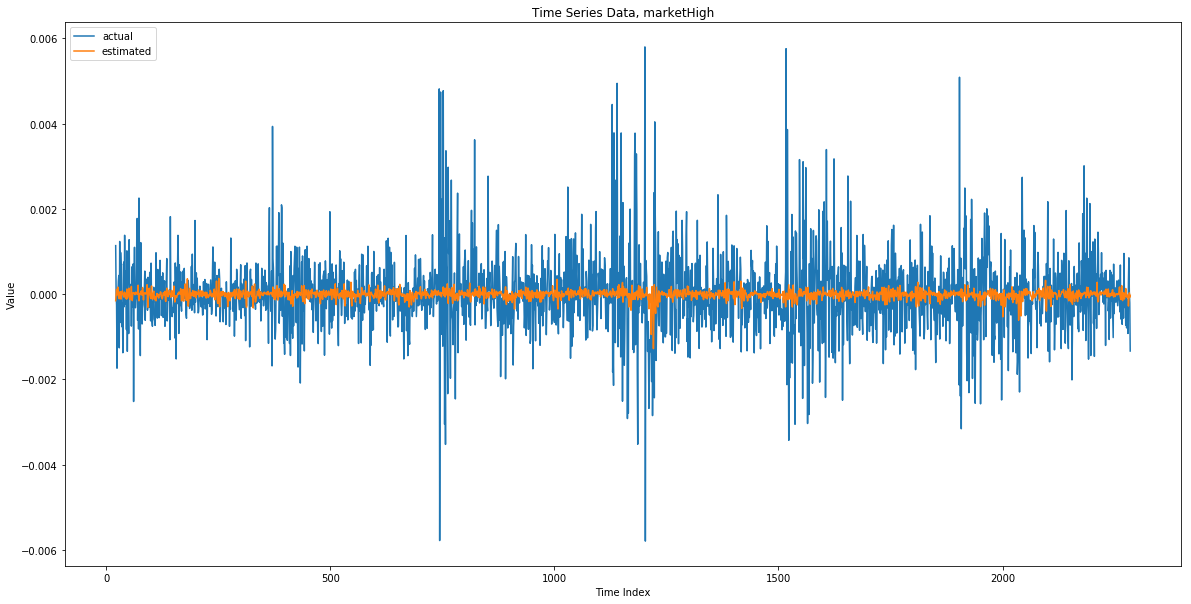

Name of current column: marketLow
Evaluation RMSE 0.00093
Evaluation MAE 0.00063


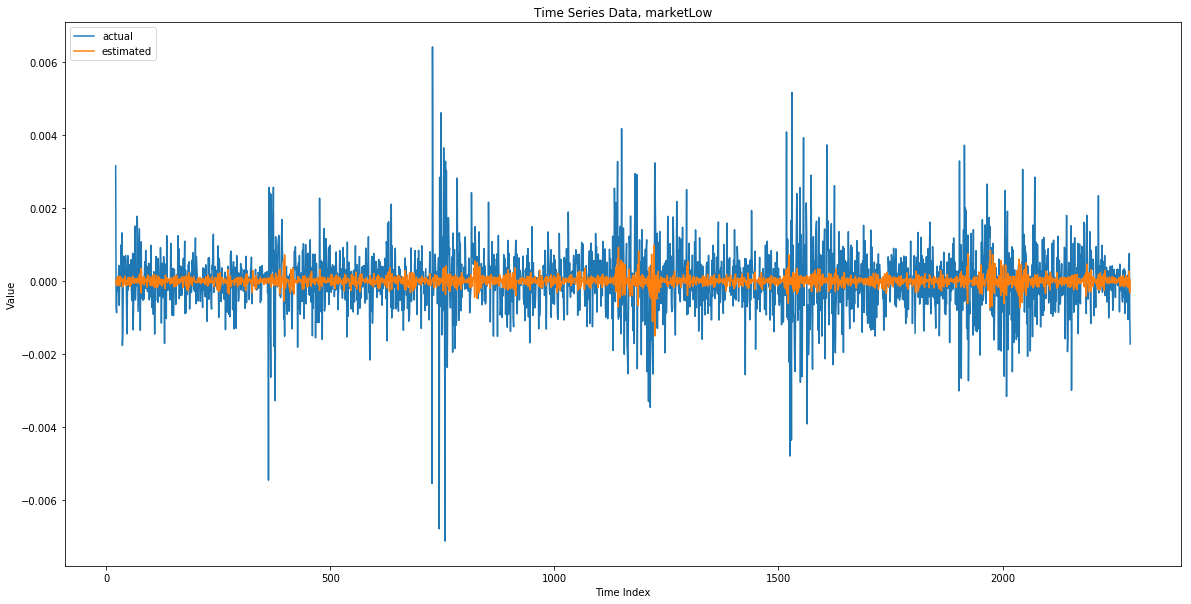

Name of current column: marketHigh_3
Evaluation RMSE 0.00147
Evaluation MAE 0.00106


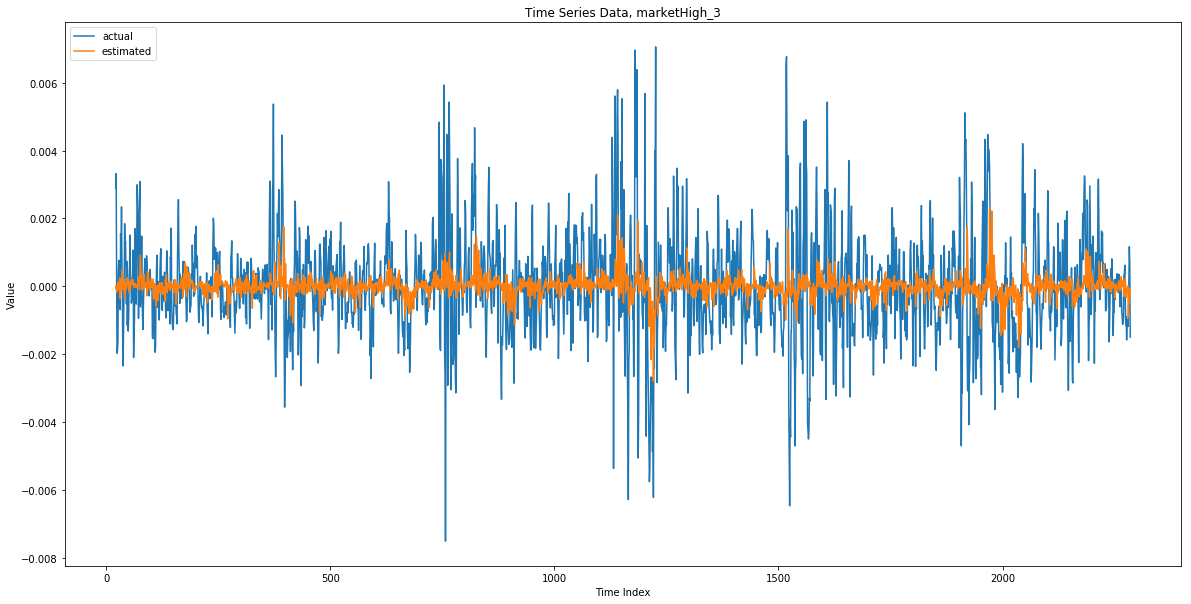

Name of current column: marketLow_3
Evaluation RMSE 0.00147
Evaluation MAE 0.00105


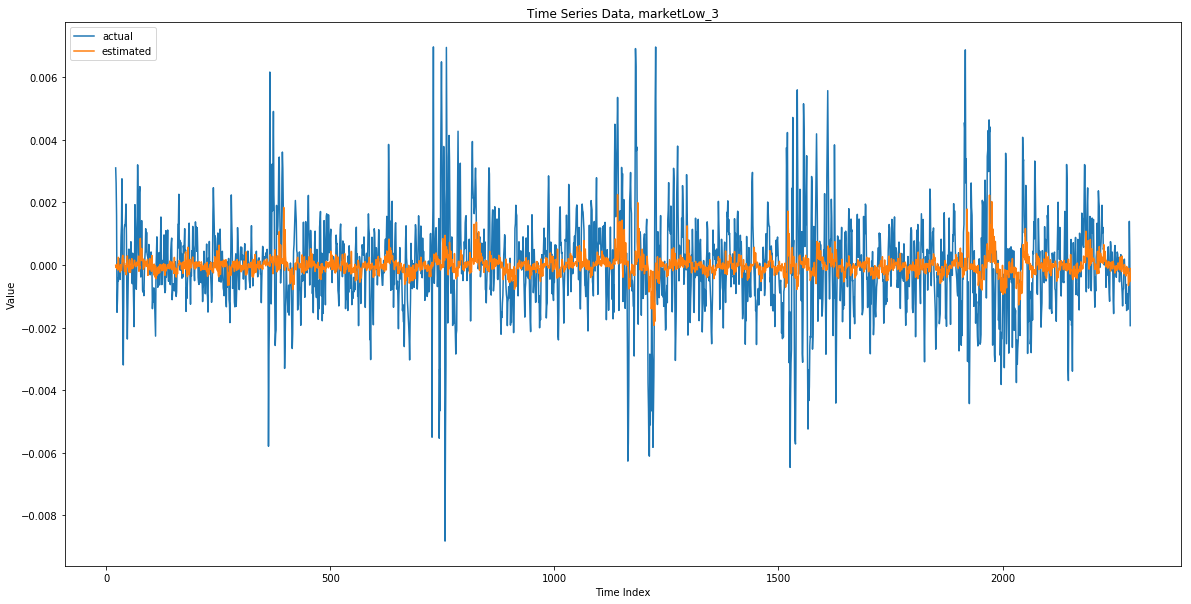

Name of current column: marketHigh_5
Evaluation RMSE 0.00179
Evaluation MAE 0.00129


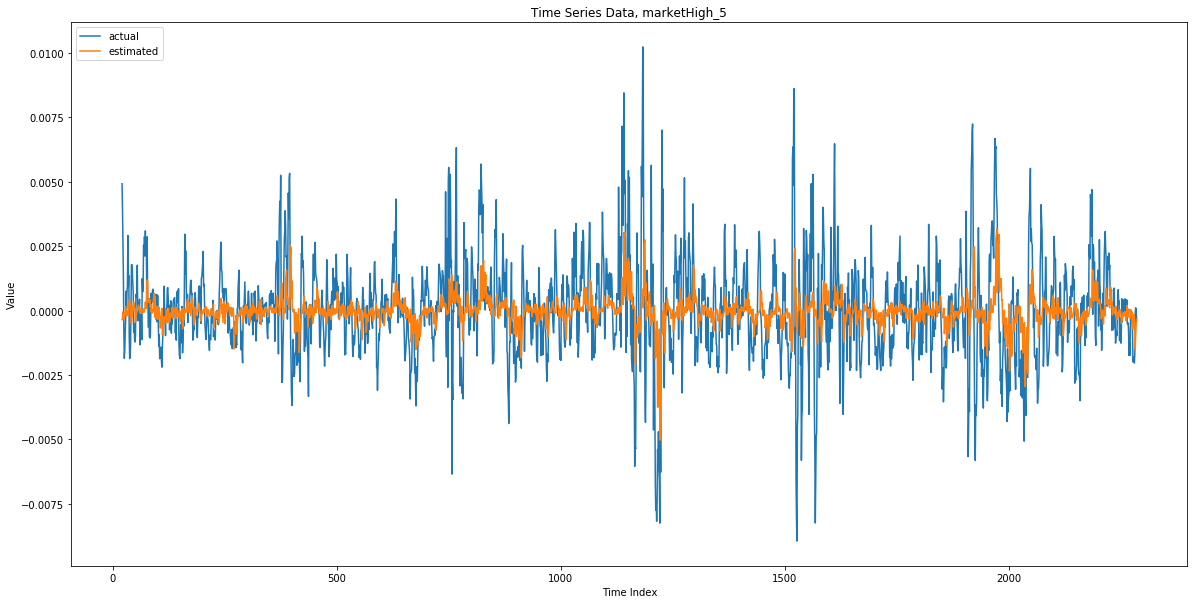

Name of current column: marketLow_5
Evaluation RMSE 0.00182
Evaluation MAE 0.00131


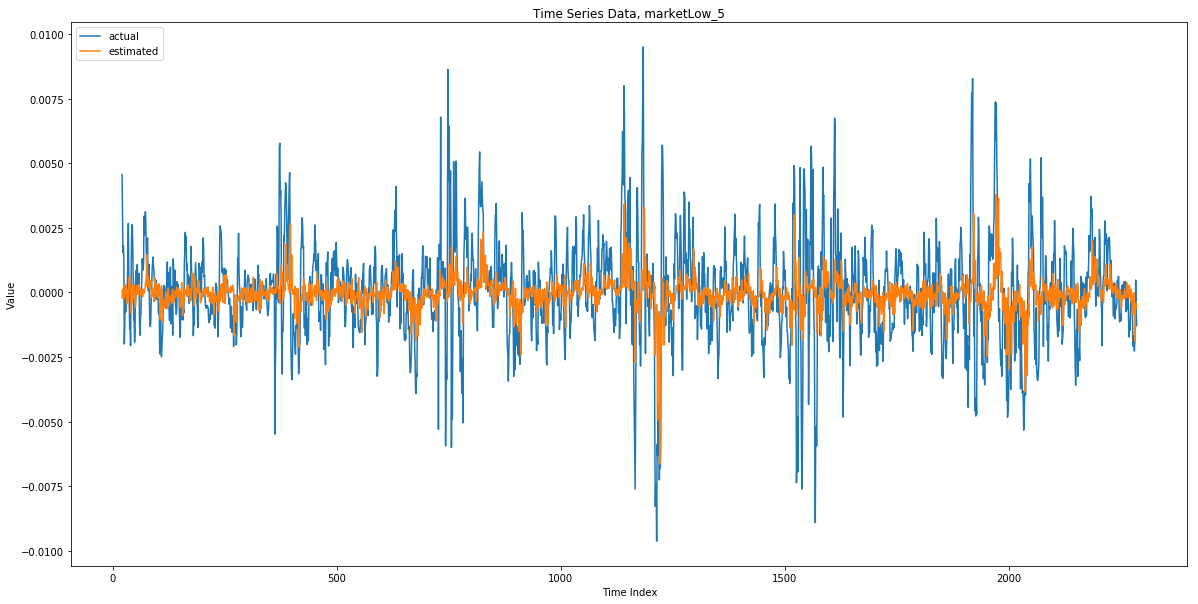

Name of current column: marketHigh_10
Evaluation RMSE 0.0021
Evaluation MAE 0.00153


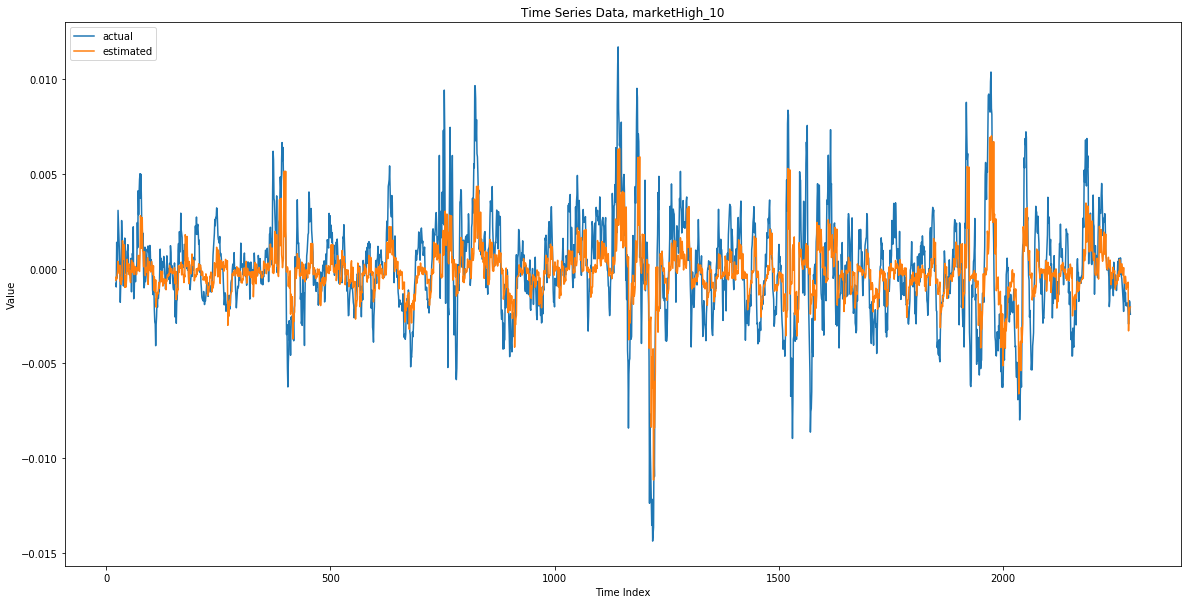

Name of current column: marketLow_10
Evaluation RMSE 0.00225
Evaluation MAE 0.00163


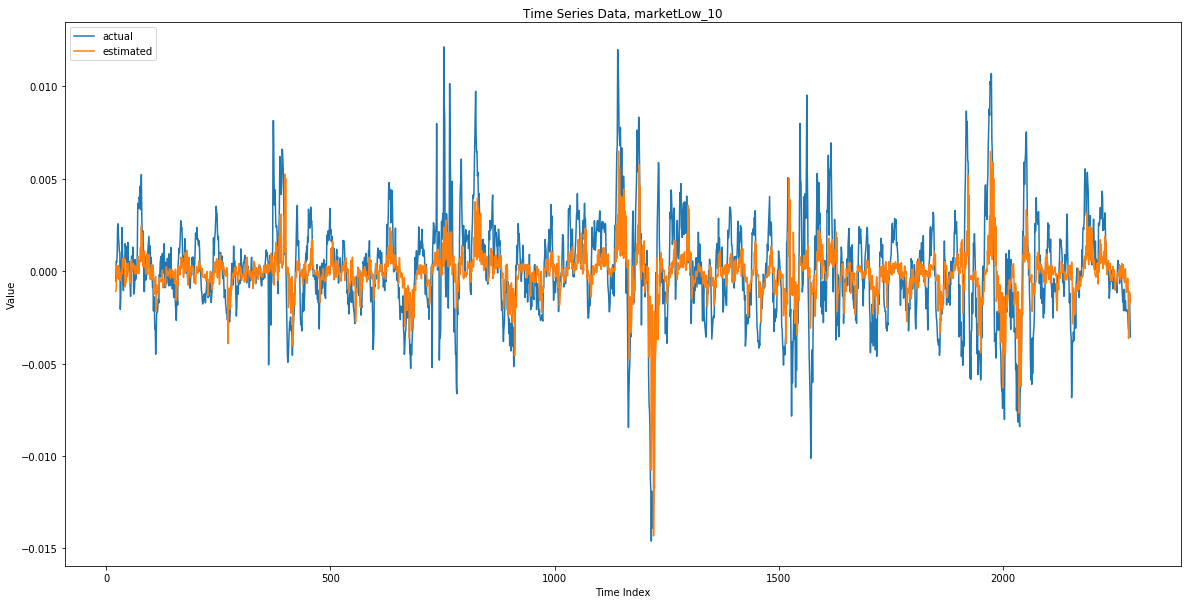

Name of current column: marketHigh_20
Evaluation RMSE 0.00234
Evaluation MAE 0.00178


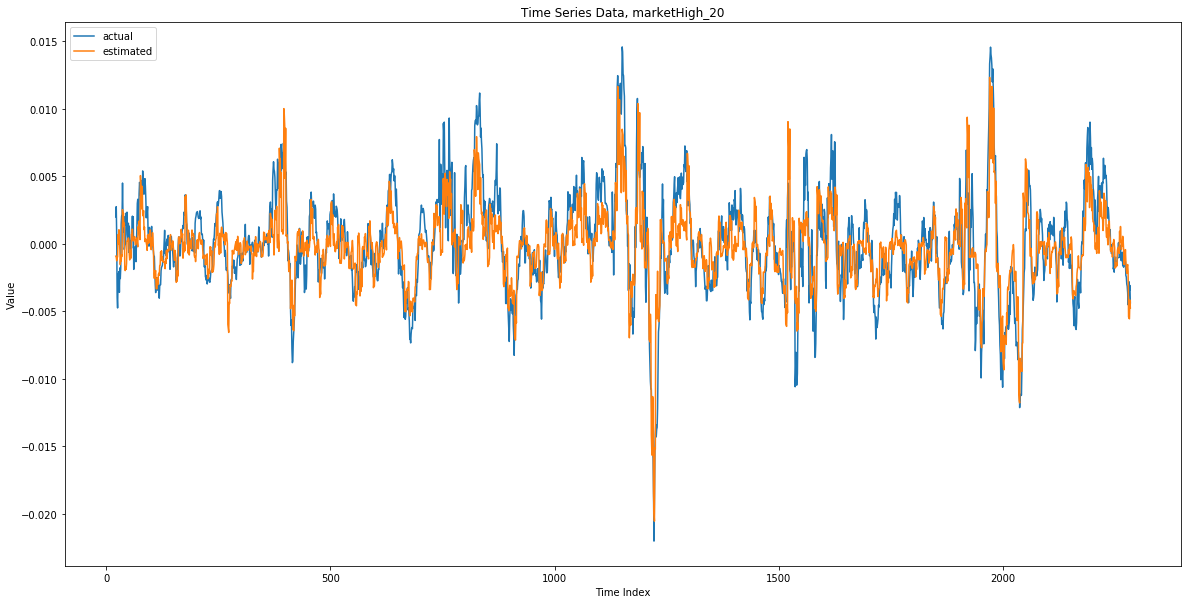

Name of current column: marketLow_20
Evaluation RMSE 0.00266
Evaluation MAE 0.00199


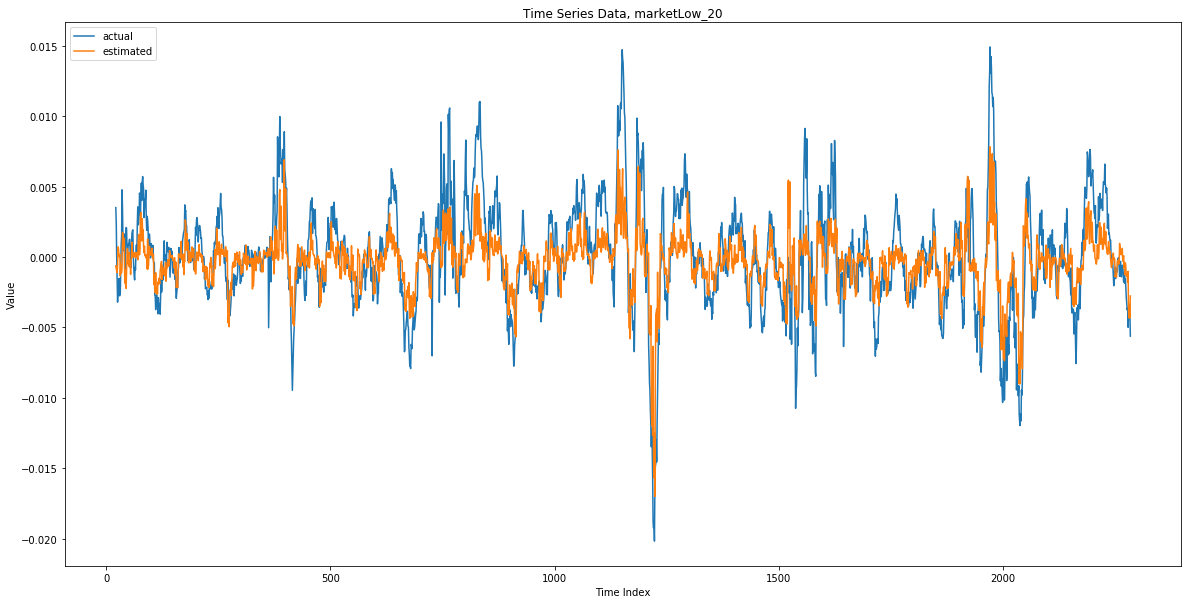

In [149]:
for test_col, name in zip(columns_of_interest, columns_of_interest_name):
    rmse = compute_rmse(y_current_actual[:, test_col], y_current_estimated[:, test_col])
    mae = compute_mae(y_current_actual[:, test_col], y_current_estimated[:, test_col])
    print("Name of current column: {}".format(name))
    print("Evaluation RMSE {}".format(rmse))
    print("Evaluation MAE {}".format(mae))
    plt.figure(figsize=(20, 10))

    plt.title("Time Series Data, {}".format(name))
    plt.plot(test_dates[WINDOW_TO_OMIT+1:], y_current_actual[   :,test_col], label='actual')
    plt.plot(test_dates[WINDOW_TO_OMIT+1:], y_current_estimated[:,test_col], label='estimated')
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    plt.legend(loc=2)
    plt.show()